# Human Action Recognition Report

# Human Action Recognition is a field of computer vision and deep learning that involves the development of algorithms and models to automatically detect, classify, and understand human actions. HAR aims to teach machines to recognize and interpret various human activities . 

# Objective: The objective of the Video Action Recognition project is to construct a deep learning model with the ability to identify and categorize human actions within videos.These actions are segmented into various classes, such as "JumpRope", "JumpingJack", "Kayaking","HorseRiding",  "Swing", "TaiChi","WalkingWithDog","PlayingViolin" and "VolleyballSpiking". The model analyzes a sequence of video frames and makes predictions about the specific action being executed.

# Dependencies: 

# 1. NumPy                    
# 2.`train_test_split`
# 3. Keras is a high-level API which is integrated with TensorFlow .
# 4. OpenCV 

# DATASET: The dataset is required for model training and provided  we have provided location to dataset and ensured that the dataset is downloaded and organized. Dataset used is UCF50 which consist of 50 action class each consist of videos . Its kinetic  dataset.

## **Code Implementation**

# pretrained network performance

# Here we have imports necessary libraries for data handling, machine learning, and computer vision and Specifies the directory where the UCF50 dataset is located.And Defines image dimensions and other parameters. list the classes to be recognized. 

In [1]:
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
import os 
import cv2

# Set the path to your UCF50 dataset directory
DATASET_DIR = r'C:\Users\admin\Downloads\UCF50\UCF50'
IMAGE_HEIGHT, IMAGE_WIDTH = 64, 64
SEQUENCE_LENGTH = 10
CHANNELS = 3  

# Specify the list containing the names of the classes used for training.
# Specify the list containing the names of the classes used for training.
CLASSES_LIST =  [ "JumpRope", "JumpingJack", "Kayaking","HorseRiding",  "Swing", "TaiChi","WalkingWithDog","PlayingViolin",
    "VolleyballSpiking"]


# Here it involves extracting  frames from a video and preprocess them.It takes the path of a video as input. It initializes an empty list, `frames_list`, to store the preprocessed frames.

In [2]:
def frames_extraction(video_path):
    '''
    This function extracts frames from a video after resizing and normalizing them.
    Args:
        video_path: Path of the video in the disk.
    Returns:
        frames_list: List containing resized and normalized frames of the video.
    '''
    frames_list = []
    video_reader = cv2.VideoCapture(video_path)
    video_frames_count = int(video_reader.get(cv2.CAP_PROP_FRAME_COUNT))
    skip_frames_window = max(int(video_frames_count / SEQUENCE_LENGTH), 1)
    
    for frame_counter in range(SEQUENCE_LENGTH):
        video_reader.set(cv2.CAP_PROP_POS_FRAMES, frame_counter * skip_frames_window)
        success, frame = video_reader.read()
        if not success:
            break
        resized_frame = cv2.resize(frame, (IMAGE_HEIGHT, IMAGE_WIDTH))
        normalized_frame = resized_frame / 255
        frames_list.append(normalized_frame)
    
    video_reader.release()
    return frames_list



# Three empty lists is created: `features` to store video frames, `labels` to store class labels, and `video_files_paths` to store the paths of video files. If the number of frames extracted matches the specified `SEQUENCE_LENGTH`, it appends the frames to the `features` list, the class index to the `labels` list, and the video file path to the `video_files_paths` list. After processing all videos for all classes, it converts the `features` and `labels` lists into NumPy arrays . 

In [3]:
# Function to create the dataset
def create_dataset():
    features = []
    labels = []
    video_files_paths = []

    for class_index, class_name in enumerate(CLASSES_LIST):
        print(f'Extracting Data of Class: {class_name}')
        class_dir = os.path.join(DATASET_DIR, class_name)
        files_list = os.listdir(class_dir)

        for file_name in files_list:
            video_file_path = os.path.join(class_dir, file_name)
            frames = frames_extraction(video_file_path)

            if len(frames) == SEQUENCE_LENGTH:
                features.append(frames)
                labels.append(class_index)
                video_files_paths.append(video_file_path)

    features = np.array(features)
    labels = np.array(labels)
    return features, labels, video_files_paths

# Create the dataset
features, labels, video_files_paths = create_dataset()

# One-hot encode the labels
one_hot_encoded_labels = to_categorical(labels)



Extracting Data of Class: JumpRope
Extracting Data of Class: JumpingJack
Extracting Data of Class: Kayaking
Extracting Data of Class: HorseRiding
Extracting Data of Class: Swing
Extracting Data of Class: TaiChi
Extracting Data of Class: WalkingWithDog
Extracting Data of Class: PlayingViolin
Extracting Data of Class: VolleyballSpiking


# The dataset is been divided into training and temporary set where training set is used for training the model and temporary set is again divided into validation and testing set. shuffle=True argument ensures that the data within each set is randomly shuffled.

In [4]:
from sklearn.model_selection import train_test_split

# Define the sizes for train, validation, and test sets
train_size = 0.60
validation_size = 0.20
test_size = 0.20

# Split the dataset into train and temp sets
seed_constant = 42
features_train, features_temp, labels_train, labels_temp = train_test_split(features, one_hot_encoded_labels,
                                                                            test_size=(1 - train_size),
                                                                            shuffle=True,
                                                                            random_state=seed_constant)

# Further split the temp set into validation and test sets
relative_validation_size = validation_size / (validation_size + test_size)
features_validation, features_test, labels_validation, labels_test = train_test_split(features_temp, labels_temp,
                                                                                        test_size=relative_validation_size,
                                                                                        shuffle=True,
                                                                                        random_state=seed_constant)


# Shape of dataset :Dataset is been divided where 60% is training dataset,20% is testing dataset and 20% is testing dataset.

In [5]:
print("Shape of Training Set (features_train):", features_train.shape)
print("Shape of Training Set (labels_train):", labels_train.shape)

print("Shape of Validation Set (features_validation):", features_validation.shape)
print("Shape of Validation Set (labels_validation):", labels_validation.shape)

print("Shape of Test Set (features_test):", features_test.shape)
print("Shape of Test Set (labels_test):", labels_test.shape)


Shape of Training Set (features_train): (720, 10, 64, 64, 3)
Shape of Training Set (labels_train): (720, 9)
Shape of Validation Set (features_validation): (240, 10, 64, 64, 3)
Shape of Validation Set (labels_validation): (240, 9)
Shape of Test Set (features_test): (241, 10, 64, 64, 3)
Shape of Test Set (labels_test): (241, 9)


# We have used MobileNetV2 model

In [6]:
import tensorflow as tf
from tensorflow.keras.layers import Input, TimeDistributed, Flatten, Dense, LSTM
from tensorflow.keras.models import Model
from tensorflow.keras.applications import MobileNetV2

# Constants
NUM_CLASSES = 9
IMAGE_CHANNELS = 3  # Input image dimensions

# Define the base model (MobileNetV2)
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(IMAGE_HEIGHT, IMAGE_WIDTH, IMAGE_CHANNELS))

# Freeze the layers of the base model
for layer in base_model.layers:
    layer.trainable = False

# Define the model architecture
input_layer = Input(shape=(SEQUENCE_LENGTH, IMAGE_HEIGHT, IMAGE_WIDTH, IMAGE_CHANNELS))
time_distributed_layer = TimeDistributed(base_model)(input_layer)
flatten_layer = TimeDistributed(Flatten())(time_distributed_layer)
lstm_layer = LSTM(128)(flatten_layer)  # You can adjust the LSTM units as needed
output_layer = Dense(NUM_CLASSES, activation='softmax')(lstm_layer)

model = Model(inputs=input_layer, outputs=output_layer)

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Print the model summary
model.summary()

# Train the model
history = model.fit(features_train, labels_train, validation_data=(features_test, labels_test), epochs=10, batch_size=16)

# Evaluate the model
test_loss, test_accuracy = model.evaluate(features_test, labels_test)
print(f'Test Loss: {test_loss:.4f}')
print(f'Test Accuracy: {test_accuracy:.4f}')


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 10, 64, 64, 3)]   0         
                                                                 
 time_distributed (TimeDist  (None, 10, 2, 2, 1280)    2257984   
 ributed)                                                        
                                                                 
 time_distributed_1 (TimeDi  (None, 10, 5120)          0         
 stributed)                                                      
                                                                 
 lstm (LSTM)                 (None, 128)               2687488   
                                                                 
 dense (Dense)               (None, 9)                 1161      
                                                                 
Total params: 4946633 (18.87 MB)
Trainable params: 2688649 (1

# Since the accuracy of MobileNetV2 is 93,36% the model stored                        in a path And implemented prediction.

In [7]:
model.save('MobileNetV2_model.h5')

C:\Users\admin\anaconda3\lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [8]:
from tensorflow.keras.models import load_model

# Load the trained model from your Google Drive or local directory
loaded_model = load_model('MobileNetV2_model.h5')

In [9]:
class_mapping = {0: 'JumpRope',
                 1: 'JumpingJack', 
                 2: 'Kayaking',
                 3: 'HorseRiding', 
                 4: 'Swing',
                 5: 'TaiChi',
                 6: 'WalkingWithDog',
                 7: 'PlayingViolin',
                 8: 'VolleyballSpiking'}

# This code reads frames from a video file, processes them in sequences of 10 frames, and predicts human action classes using a pre-trained deep learning model. It prints the predicted action and its confidence score if it's above a defined threshold. The code uses OpenCV for video handling and TensorFlow Keras for model prediction.

In [10]:
import cv2
import numpy as np
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input

# Initialize video capture from the input video file
input_video_path = 'videoplayback.mp4'
cap = cv2.VideoCapture(input_video_path)

# Initialize variables for video frames and predictions
frames = []
predictions = []

# Set a threshold confidence score for top frames
confidence_threshold = 0.75  # Adjust the threshold as needed

# Define a function to preprocess input frames from the video
def preprocess_frame(frame):
    frame = cv2.resize(frame, (64, 64))  # Adjust the target size as needed
    img_array = image.img_to_array(frame)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = preprocess_input(img_array)
    return img_array

while True:
    # Read a frame from the video
    ret, frame = cap.read()

    if not ret:
        break  # Break the loop if no more frames are available

    # Preprocess the frame
    input_data = preprocess_frame(frame)
    frames.append(input_data)

    if len(frames) == 10:
        # If we have accumulated 10 frames, make predictions for the video sequence
        sequence = np.stack(frames, axis=1)  # Stack frames to create a sequence
        prediction = model.predict(sequence)
        predictions.append(prediction)

        # Check the confidence score of the top prediction
        top_confidence = prediction.max()

        # Print predictions for frames with confidence above the threshold
        if top_confidence > confidence_threshold:
            class_index = np.argmax(prediction[0])  # Get the class index with the highest probability
            class_name = class_mapping.get(class_index, 'Unknown')  # Map the index to a class name
            print(f'Frame {len(predictions)}: Predicted class: {class_name} (Confidence: {top_confidence:.2%})')

        # Clear the frame buffer
        frames = []

# Release the video capture object
cap.release()


1/1 [==============================] - 4s 4s/step
Frame 1: Predicted class: WalkingWithDog (Confidence: 86.12%)
1/1 [==============================] - 0s 103ms/step
Frame 2: Predicted class: Swing (Confidence: 87.34%)
1/1 [==============================] - 0s 108ms/step
Frame 4: Predicted class: WalkingWithDog (Confidence: 96.56%)
1/1 [==============================] - 0s 100ms/step
Frame 5: Predicted class: WalkingWithDog (Confidence: 82.60%)
1/1 [==============================] - 0s 99ms/step
Frame 6: Predicted class: WalkingWithDog (Confidence: 97.05%)
1/1 [==============================] - 0s 101ms/step
Frame 7: Predicted class: WalkingWithDog (Confidence: 87.29%)
1/1 [==============================] - 0s 96ms/step
Frame 8: Predicted class: WalkingWithDog (Confidence: 92.55%)
1/1 [==============================] - 0s 110ms/step
Frame 9: Predicted class: WalkingWithDog (Confidence: 98.24%)
1/1 [==============================] - 0s 99ms/step
Frame 10: Predicted class: WalkingWithDog 

# obtained confusion matrix for evaluating the performance of a classification model the trained model is considered to make predictions on the test data. It converts the one-hot encoded predictions into class labels by finding the index of the highest probability in each prediction .even the lables from one-hot encoded fromat to class labels by finding index of true class. Then calculates the confusion matrix using scikit-learn's `confusion_matrix` function.

8/8 [==============================] - 6s 762ms/step


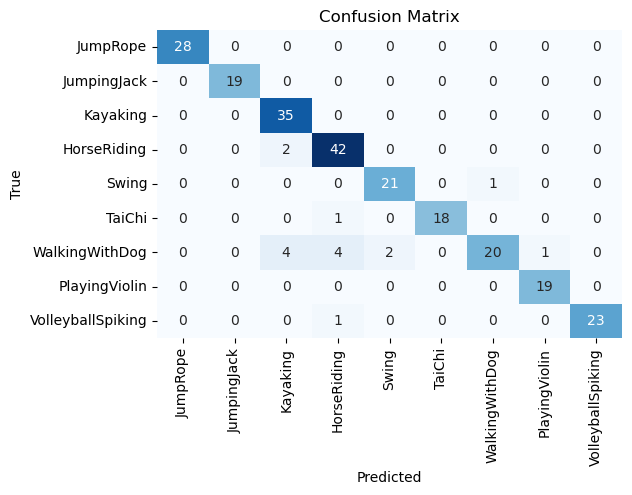

In [11]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Assuming you've already trained your model and have it stored in the 'model' variable.

# Make predictions on the test data
predictions = model.predict(features_test)
predicted_classes = np.argmax(predictions, axis=1)  # Convert one-hot encoded predictions to class labels

# Convert one-hot encoded true labels to class labels
true_classes = np.argmax(labels_test, axis=1)

# Compute the confusion matrix
confusion_mtx = confusion_matrix(true_classes, predicted_classes)

# Visualize the confusion matrix using seaborn and matplotlib
plt.figure(figsize=(6, 4))
sns.heatmap(confusion_mtx, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=CLASSES_LIST,
            yticklabels=CLASSES_LIST)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()


# Here we have calculated both the overall accuracy and class-specific accuracy.

In [12]:
import numpy as np
from sklearn.metrics import confusion_matrix, accuracy_score

# Assuming you've already trained your model and have it stored in the 'model' variable.

# Make predictions on the test data
predictions = model.predict(features_test)
predicted_classes = np.argmax(predictions, axis=1)  # Convert one-hot encoded predictions to class labels

# Convert one-hot encoded true labels to class labels
true_classes = np.argmax(labels_test, axis=1)

# Compute the confusion matrix
confusion_mtx = confusion_matrix(true_classes, predicted_classes)

# Calculate accuracy
accuracy = accuracy_score(true_classes, predicted_classes)

# Print accuracy
print(f'Overall Accuracy: {accuracy:.2%}')

# Print prediction count for each class
for class_index, class_name in enumerate(CLASSES_LIST):
    class_count = np.sum(true_classes == class_index)
    class_accuracy = np.sum((true_classes == class_index) & (true_classes == predicted_classes)) / class_count
    print(f'Class: {class_name}')
    print(f'Accuracy: {class_accuracy:.2%}')
    print(f'Predicted {class_count} instances correctly out of {class_count}\n')


8/8 [==============================] - 6s 751ms/step
Overall Accuracy: 93.36%
Class: JumpRope
Accuracy: 100.00%
Predicted 28 instances correctly out of 28

Class: JumpingJack
Accuracy: 100.00%
Predicted 19 instances correctly out of 19

Class: Kayaking
Accuracy: 100.00%
Predicted 35 instances correctly out of 35

Class: HorseRiding
Accuracy: 95.45%
Predicted 44 instances correctly out of 44

Class: Swing
Accuracy: 95.45%
Predicted 22 instances correctly out of 22

Class: TaiChi
Accuracy: 94.74%
Predicted 19 instances correctly out of 19

Class: WalkingWithDog
Accuracy: 64.52%
Predicted 31 instances correctly out of 31

Class: PlayingViolin
Accuracy: 100.00%
Predicted 19 instances correctly out of 19

Class: VolleyballSpiking
Accuracy: 95.83%
Predicted 24 instances correctly out of 24



# Retrained with new activity (we have downloaded certain video related to bowling and created folder and added it into UCF50 dataset and repeated the above steps to see the performance)

In [13]:
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
import os 
import cv2

# Set the path to your UCF50 dataset directory
DATASET_DIR = r'C:\Users\admin\Downloads\UCF50\UCF50'
IMAGE_HEIGHT, IMAGE_WIDTH = 64, 64
SEQUENCE_LENGTH = 10
CHANNELS = 3  

# Specify the list containing the names of the classes used for training.
# Specify the list containing the names of the classes used for training.
CLASSES_LIST =  [ "JumpRope", "JumpingJack", "Kayaking","HorseRiding", "bowling", "Swing", "TaiChi","WalkingWithDog","PlayingViolin",
    "VolleyballSpiking"]


In [14]:
def frames_extraction(video_path):
    '''
    This function extracts frames from a video after resizing and normalizing them.
    Args:
        video_path: Path of the video in the disk.
    Returns:
        frames_list: List containing resized and normalized frames of the video.
    '''
    frames_list = []
    video_reader = cv2.VideoCapture(video_path)
    video_frames_count = int(video_reader.get(cv2.CAP_PROP_FRAME_COUNT))
    skip_frames_window = max(int(video_frames_count / SEQUENCE_LENGTH), 1)
    
    for frame_counter in range(SEQUENCE_LENGTH):
        video_reader.set(cv2.CAP_PROP_POS_FRAMES, frame_counter * skip_frames_window)
        success, frame = video_reader.read()
        if not success:
            break
        resized_frame = cv2.resize(frame, (IMAGE_HEIGHT, IMAGE_WIDTH))
        normalized_frame = resized_frame / 255
        frames_list.append(normalized_frame)
    
    video_reader.release()
    return frames_list


In [15]:
# Function to create the dataset
def create_dataset():
    features = []
    labels = []
    video_files_paths = []

    for class_index, class_name in enumerate(CLASSES_LIST):
        print(f'Extracting Data of Class: {class_name}')
        class_dir = os.path.join(DATASET_DIR, class_name)
        files_list = os.listdir(class_dir)

        for file_name in files_list:
            video_file_path = os.path.join(class_dir, file_name)
            frames = frames_extraction(video_file_path)

            if len(frames) == SEQUENCE_LENGTH:
                features.append(frames)
                labels.append(class_index)
                video_files_paths.append(video_file_path)

    features = np.array(features)
    labels = np.array(labels)
    return features, labels, video_files_paths

# Create the dataset
features, labels, video_files_paths = create_dataset()

# One-hot encode the labels
one_hot_encoded_labels = to_categorical(labels)



Extracting Data of Class: JumpRope
Extracting Data of Class: JumpingJack
Extracting Data of Class: Kayaking
Extracting Data of Class: HorseRiding
Extracting Data of Class: bowling
Extracting Data of Class: Swing
Extracting Data of Class: TaiChi
Extracting Data of Class: WalkingWithDog
Extracting Data of Class: PlayingViolin
Extracting Data of Class: VolleyballSpiking


In [16]:
from sklearn.model_selection import train_test_split

# Define the sizes for train, validation, and test sets
train_size = 0.60
validation_size = 0.20
test_size = 0.20

# Split the dataset into train and temp sets
seed_constant = 42
features_train, features_temp, labels_train, labels_temp = train_test_split(features, one_hot_encoded_labels,
                                                                            test_size=(1 - train_size),
                                                                            shuffle=True,
                                                                            random_state=seed_constant)

# Further split the temp set into validation and test sets
relative_validation_size = validation_size / (validation_size + test_size)
features_validation, features_testx, labels_validation, labels_test = train_test_split(features_temp, labels_temp,
                                                                                        test_size=relative_validation_size,
                                                                                        shuffle=True,
                                                                                        random_state=seed_constant)


In [17]:
print("Shape of Training Set (features_train):", features_train.shape)
print("Shape of Training Set (labels_train):", labels_train.shape)

print("Shape of Validation Set (features_validation):", features_validation.shape)
print("Shape of Validation Set (labels_validation):", labels_validation.shape)

print("Shape of Test Set (features_testx):", features_testx.shape)
print("Shape of Test Set (labels_test):", labels_test.shape)


Shape of Training Set (features_train): (740, 10, 64, 64, 3)
Shape of Training Set (labels_train): (740, 10)
Shape of Validation Set (features_validation): (247, 10, 64, 64, 3)
Shape of Validation Set (labels_validation): (247, 10)
Shape of Test Set (features_testx): (247, 10, 64, 64, 3)
Shape of Test Set (labels_test): (247, 10)


In [18]:
import tensorflow as tf
from tensorflow.keras.layers import Input, TimeDistributed, Flatten, Dense, LSTM
from tensorflow.keras.models import Model
from tensorflow.keras.applications import MobileNetV2

# Constants
NUM_CLASSES = 10
IMAGE_CHANNELS = 3  # Input image dimensions

# Define the base model (MobileNetV2)
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(IMAGE_HEIGHT, IMAGE_WIDTH, IMAGE_CHANNELS))

# Freeze the layers of the base model
for layer in base_model.layers:
    layer.trainable = False

# Define the model architecture
input_layer = Input(shape=(SEQUENCE_LENGTH, IMAGE_HEIGHT, IMAGE_WIDTH, IMAGE_CHANNELS))
time_distributed_layer = TimeDistributed(base_model)(input_layer)
flatten_layer = TimeDistributed(Flatten())(time_distributed_layer)
lstm_layer = LSTM(128)(flatten_layer)  # You can adjust the LSTM units as needed
output_layer = Dense(NUM_CLASSES, activation='softmax')(lstm_layer)

model = Model(inputs=input_layer, outputs=output_layer)

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Print the model summary
model.summary()

# Train the model
history = model.fit(features_train, labels_train, validation_data=(features_testx, labels_test), epochs=10, batch_size=16)

# Evaluate the model
test_loss, test_accuracy = model.evaluate(features_testx, labels_test)
print(f'Test Loss: {test_loss:.4f}')
print(f'Test Accuracy: {test_accuracy:.4f}')


Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 10, 64, 64, 3)]   0         
                                                                 
 time_distributed_2 (TimeDi  (None, 10, 2, 2, 1280)    2257984   
 stributed)                                                      
                                                                 
 time_distributed_3 (TimeDi  (None, 10, 5120)          0         
 stributed)                                                      
                                                                 
 lstm_1 (LSTM)               (None, 128)               2687488   
                                                                 
 dense_1 (Dense)             (None, 10)                1290      
                                                                 
Total params: 4946762 (18.87 MB)
Trainable params: 2688778 

In [19]:
model.save('new_MobileNetV2_model.h5')

C:\Users\admin\anaconda3\lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [20]:
from tensorflow.keras.models import load_model

# Load the trained model from your Google Drive or local directory
loaded_model = load_model('new_MobileNetV2_model.h5')

In [21]:
class_mapping = {0: 'JumpRope',
                 1: 'JumpingJack', 
                 2: 'Kayaking',
                 3: 'HorseRiding',
                 4: 'bowling',
                 5: 'Swing',
                 6: 'TaiChi',
                 7: 'WalkingWithDog',
                 8: 'PlayingViolin',
                 9: 'VolleyballSpiking'}

In [22]:
import cv2
import numpy as np
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input

# Initialize video capture from the input video file
input_video_path = 'videoplayback.mp4'
cap = cv2.VideoCapture(input_video_path)

# Initialize variables for video frames and predictions
frames = []
predictions = []

# Set a threshold confidence score for top frames
confidence_threshold = 0.75  # Adjust the threshold as needed

# Define a function to preprocess input frames from the video
def preprocess_frame(frame):
    frame = cv2.resize(frame, (64, 64))  # Adjust the target size as needed
    img_array = image.img_to_array(frame)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = preprocess_input(img_array)
    return img_array

while True:
    # Read a frame from the video
    ret, frame = cap.read()

    if not ret:
        break  # Break the loop if no more frames are available

    # Preprocess the frame
    input_data = preprocess_frame(frame)
    frames.append(input_data)

    if len(frames) == 10:
        # If we have accumulated 10 frames, make predictions for the video sequence
        sequence = np.stack(frames, axis=1)  # Stack frames to create a sequence
        prediction = model.predict(sequence)
        predictions.append(prediction)

        # Check the confidence score of the top prediction
        top_confidence = prediction.max()

        # Print predictions for frames with confidence above the threshold
        if top_confidence > confidence_threshold:
            class_index = np.argmax(prediction[0])  # Get the class index with the highest probability
            class_name = class_mapping.get(class_index, 'Unknown')  # Map the index to a class name
            print(f'Frame {len(predictions)}: Predicted class: {class_name} (Confidence: {top_confidence:.2%})')

        # Clear the frame buffer
        frames = []

# Release the video capture object
cap.release()


1/1 [==============================] - 0s 129ms/step
Frame 5: Predicted class: Swing (Confidence: 85.81%)
1/1 [==============================] - 0s 128ms/step
Frame 6: Predicted class: WalkingWithDog (Confidence: 82.33%)
1/1 [==============================] - 0s 128ms/step
Frame 7: Predicted class: WalkingWithDog (Confidence: 79.84%)
1/1 [==============================] - 0s 108ms/step
Frame 9: Predicted class: WalkingWithDog (Confidence: 91.72%)
1/1 [==============================] - 0s 112ms/step
Frame 10: Predicted class: WalkingWithDog (Confidence: 96.22%)
1/1 [==============================] - 0s 109ms/step
Frame 11: Predicted class: WalkingWithDog (Confidence: 76.06%)
1/1 [==============================] - 0s 127ms/step
Frame 12: Predicted class: WalkingWithDog (Confidence: 82.59%)
1/1 [==============================] - 0s 114ms/step
Frame 14: Predicted class: Swing (Confidence: 86.18%)
1/1 [==============================] - 0s 118ms/step
Frame 15: Predicted class: WalkingWithDog

8/8 [==============================] - 6s 783ms/step


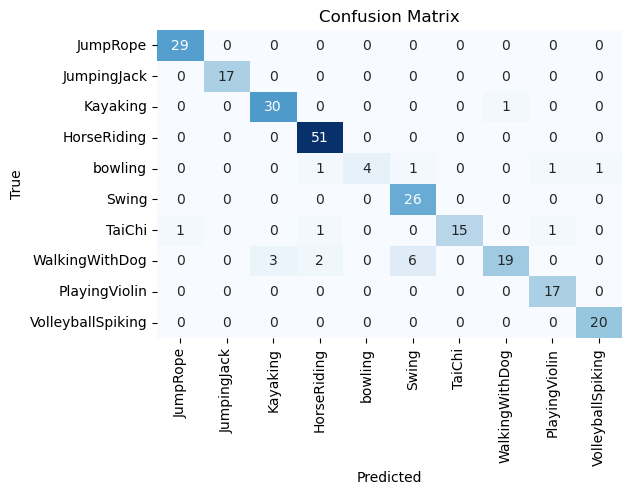

In [23]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Assuming you've already trained your model and have it stored in the 'model' variable.

# Make predictions on the test data
predictions = model.predict(features_testx)
predicted_classes = np.argmax(predictions, axis=1)  # Convert one-hot encoded predictions to class labels

# Convert one-hot encoded true labels to class labels
true_classes = np.argmax(labels_test, axis=1)

# Compute the confusion matrix
confusion_mtx = confusion_matrix(true_classes, predicted_classes)

# Visualize the confusion matrix using seaborn and matplotlib
plt.figure(figsize=(6, 4))
sns.heatmap(confusion_mtx, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=CLASSES_LIST,
            yticklabels=CLASSES_LIST)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()


In [24]:
import numpy as np
from sklearn.metrics import confusion_matrix, accuracy_score

# Assuming you've already trained your model and have it stored in the 'model' variable.

# Make predictions on the test data
predictions = model.predict(features_testx)
predicted_classes = np.argmax(predictions, axis=1)  # Convert one-hot encoded predictions to class labels

# Convert one-hot encoded true labels to class labels
true_classes = np.argmax(labels_test, axis=1)

# Compute the confusion matrix
confusion_mtx = confusion_matrix(true_classes, predicted_classes)

# Calculate accuracy
accuracy = accuracy_score(true_classes, predicted_classes)

# Print accuracy
print(f'Overall Accuracy: {accuracy:.2%}')

# Print prediction count for each class
for class_index, class_name in enumerate(CLASSES_LIST):
    class_count = np.sum(true_classes == class_index)
    class_accuracy = np.sum((true_classes == class_index) & (true_classes == predicted_classes)) / class_count
    print(f'Class: {class_name}')
    print(f'Accuracy: {class_accuracy:.2%}')
    print(f'Predicted {class_count} instances correctly out of {class_count}\n')


8/8 [==============================] - 6s 766ms/step
Overall Accuracy: 92.31%
Class: JumpRope
Accuracy: 100.00%
Predicted 29 instances correctly out of 29

Class: JumpingJack
Accuracy: 100.00%
Predicted 17 instances correctly out of 17

Class: Kayaking
Accuracy: 96.77%
Predicted 31 instances correctly out of 31

Class: HorseRiding
Accuracy: 100.00%
Predicted 51 instances correctly out of 51

Class: bowling
Accuracy: 50.00%
Predicted 8 instances correctly out of 8

Class: Swing
Accuracy: 100.00%
Predicted 26 instances correctly out of 26

Class: TaiChi
Accuracy: 83.33%
Predicted 18 instances correctly out of 18

Class: WalkingWithDog
Accuracy: 63.33%
Predicted 30 instances correctly out of 30

Class: PlayingViolin
Accuracy: 100.00%
Predicted 17 instances correctly out of 17

Class: VolleyballSpiking
Accuracy: 100.00%
Predicted 20 instances correctly out of 20



# created a bar plot comparing the performance of two models, MobileNetV2_model and new_MobileNetV2_model

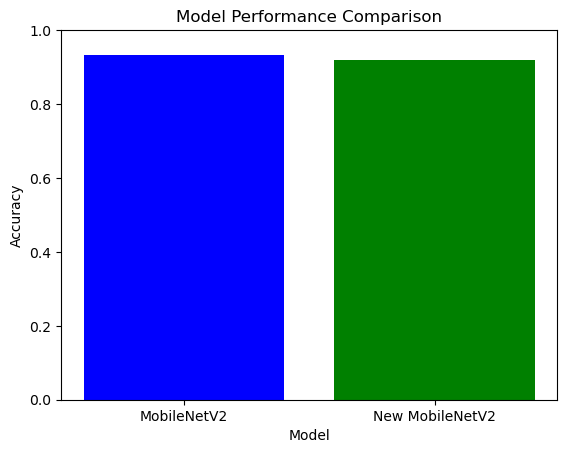

In [25]:
import matplotlib.pyplot as plt
import numpy as np


mobileNetV2_accuracy =  0.9336
newMobileNetV2_accuracy = 0.9190

# Names for the models
model_names = ['MobileNetV2', 'New MobileNetV2']

# Accuracy values
accuracy_values = [mobileNetV2_accuracy, newMobileNetV2_accuracy]

# Create a bar plot
plt.bar(model_names, accuracy_values, color=['blue', 'green'])
plt.xlabel('Model')
plt.ylabel('Accuracy')
plt.title('Model Performance Comparison')
plt.ylim(0, 1.0)  # Set the y-axis range from 0 to 1
plt.show()


# Result:The accuracy of the original MobileNetV2 model on a original dataset is 0.9336 and the accuracy of the dataset whic include new class  MobileNetV2 model is  0.9190.The decrease in accuracy from the original dataset to the   addition of the new class  has introduced some confusion or made it more challenging for the model to distinguish between classes. This could be due to factors such as class imbalance, insufficient data for the new class, or the complexity of the added class.